<a href="https://colab.research.google.com/github/SugnikMukherjee/ModelPredictiveController/blob/main/systemIdentification_PySINDy_trial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Data Preparation**

---



In [ ]:
!pip install gekko

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 54.7 MB/s eta 0:00:00


In [ ]:
from gekko import GEKKO
import numpy as np
import pandas as pd

In [ ]:
parameters = pd.read_csv('./parameter.csv')
parameters.head()

,m,lf,lr,Cf,Cr,Iz,mu,steering_ratio,Sampling Period
0,1331,0.84,1.63,90624,90624,1500,0.5,0.0625,0.04


In [ ]:
input = pd.read_csv('./SLC_input.csv')
input

,time,Drv_DeltaSteer,Veh_Vx
0,0.000,0.0,30.000000
1,0.005,0.0,29.999664
2,0.010,0.0,29.998813
3,0.015,0.0,29.997596
4,0.020,0.0,29.996121
...,...,...,...
1996,9.980,0.0,22.403868
1997,9.985,0.0,22.402453
1998,9.990,0.0,22.401038
1999,9.995,0.0,22.399623


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import math

class DataPreparation:
   m = 0
   lf = 0
   lr = 0
   Cf = 0
   Cr = 0
   Iz = 0
   steering_ratio = 0
   Ts = 0
   K = 0
   L = 0
   P = 0

   def __init__(self, drivingProfile) -> None:
    self.m = drivingProfile['m'][0]
    self.lf = drivingProfile['lf'][0]
    self.lr = drivingProfile['lr'][0]
    self.Cf = drivingProfile['Cf'][0]
    self.Cr = drivingProfile['Cr'][0]
    self.Iz = drivingProfile['Iz'][0]
    self.steering_ratio = drivingProfile['steering_ratio'][0]
    self.Ts = drivingProfile['Sampling Period'][0]
    # self.K = np.array([[1.8639, -0.0279],[-542794.8896, 32604.6225]])
    # self.L = np.array([[-0.000000000009229, -0.000000000131049],[0.000000000135782, 0.000000001407986]])
    # self.P = np.array([[2, 1],[1,1]])

    self.K = np.array([[5.261, -0.023], [-414911.257, 57009.478]])
    self.L = 1e-8*np.array([[-0.0027, -0.0636],[0.0337, 0.5563]])
    self.P = np.array([[2, 1],[1,1]])

   def calculateParameters(self, v_x):
    A = np.array([
      np.array([(-2*self.Cf-2*self.Cr)/(self.m*v_x), -1-((2*self.Cf*self.lf - 2*self.Cr*self.lr)/(self.m*v_x*v_x))]),
      np.array([((2*self.Cr*self.lr)-(2*self.Cf*self.lf))/self.Iz, (-2*self.Cf*self.lf*self.lf-2*self.Cr*self.lr*self.lr)/(self.Iz*v_x)])
      ])
    B = np.array([[(2*self.Cf)/(self.m*v_x), 0], [(2*self.Cf*self.lf)/self.Iz, 1/self.Iz]])
    C = np.array([[0, 1], [(-2*self.Cf-2*self.Cr)/self.m, -(2*self.Cf*self.lf-2*self.Cr*self.lr)/(self.m*v_x)]])
    D = np.array([[0, 0], [(2*self.Cf)/self.m, 0]])

    return [A, B, C, D]

   def computeData(self, Time, deltaSteer, Vx):
    n = math.floor(self.Ts/(Time[1]-Time[0]))

    time = [Time[i] for i in range(len(Time)) if i%n==0]
    steeringAngle = [deltaSteer[i] for i in range(len(deltaSteer)) if i%n==0]
    velocity = [Vx[i] for i in range(len(Vx)) if i%n==0]

    # u = [np.transpose(np.array([np.array([deltaSteer[0]*math.pi/180, 0])]))]
    u = [np.array([[0], [0]])]
    # x = [np.dot(np.linalg.inv(-self.K), u[0])]
    x = [np.array([[0], [0]])]
    # x_cap = [np.dot(np.linalg.inv(-self.K), u[0])]
    x_cap = [np.array([[0], [0]])]
    # A, B, C, D = self.calculateParameters(max(Vx))
    A, B, C, D = self.calculateParameters(velocity[0])
    y = [np.dot(C,x[0])]
    y_cap = [np.dot(C,x_cap[0])]

    for i in range(1, len(velocity)):
        A, B, C, D = self.calculateParameters(velocity[i-1])

        out = signal.StateSpace(A, B, C, D)
        out = out.to_discrete(self.Ts)

        r = y[i-1] - y_cap[i-1]

        x.append(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1]))
        x_cap.append(np.dot(out.A, x[i-1])+np.dot(out.B, u[i-1])+np.dot(self.L,r))

        utemp = np.dot(-self.K, x[i]) + np.array([[steeringAngle[i]*(math.pi/180)*self.steering_ratio], [0]])
        # utemp[0][0] += steeringAngle[i]*(math.pi/180)*self.steering_ratio
        utemp[0][0] %= (2*math.pi)
        u.append(utemp)

        y.append(np.dot(out.C, x[i])+np.dot(out.D, u[i]))
        y_cap.append(np.dot(out.C, x_cap[i])+np.dot(out.D, u[i]))

    Mz = []
    delta = []
    for i in range(len(u)):
        Mz.append(u[i][1][0])
        delta.append(u[i][0][0])

    r = []
    beta = []
    for i in range(len(x)):
        r.append(x[i][1][0])
        beta.append(x[i][0][0])

    r_cap = []
    beta_cap = []
    for i in range(len(x)):
        r_cap.append(x_cap[i][1][0])
        beta_cap.append(x_cap[i][0][0])

    r1 = []
    ay = []
    for i in range(len(y)):
        r1.append(y[i][0][0])
        ay.append(y[i][1][0])

    r1_cap = []
    ay_cap = []
    for i in range(len(y_cap)):
        r1_cap.append(y_cap[i][1][0])
        ay_cap.append(y_cap[i][0][0])

    return [time, velocity, Mz, delta, r, r_cap, beta, beta_cap, ay, ay_cap]

   def getOutput(self, Time, deltaSteer, Vx):
    [time, velocity, Mz, delta, r, r_cap, beta, beta_cap, ay, ay_cap] = self.computeData(Time, deltaSteer, Vx)
    return [time, r, ay]

   def getEstimatedOutput(self, Time, deltaSteer, Vx):
    [time, velocity, Mz, delta, r, r_cap, beta, beta_cap, ay, ay_cap] = self.computeData(Time, deltaSteer, Vx)
    return [time, r_cap, ay_cap]

   def getInput(self, Time, deltaSteer, Vx):
    [time, velocity, Mz, delta, r, r_cap, beta, beta_cap, ay, ay_cap] = self.computeData(Time, deltaSteer, Vx)
    return [time, velocity, delta, Mz]

   def getStates(self, Time, deltaSteer, Vx):
    [time, velocity, Mz, delta, r, r_cap, beta, beta_cap, ay, ay_cap] = self.computeData(Time, deltaSteer, Vx)
    return [time, beta, r]

   def getEstimatedStates(self, Time, deltaSteer, Vx):
    [time, velocity, Mz, delta, r, r_cap, beta, beta_cap, ay, ay_cap] = self.computeData(Time, deltaSteer, Vx)
    return [time, r_cap, beta_cap]

In [ ]:
dp = DataPreparation(parameters)
time, r, ay = dp.getOutput(input['time'], input['Drv_DeltaSteer'], input['Veh_Vx'])
time, velocity, delta, Mz = dp.getInput(input['time'], input['Drv_DeltaSteer'], input['Veh_Vx'])
time, beta, r = dp.getStates(input['time'], input['Drv_DeltaSteer'], input['Veh_Vx'])

In [ ]:
vx = input['Veh_Vx']
delta = input['Drv_DeltaSteer']

In [ ]:
time, velocity, delta, Mz = dp.getInput(input['time'], input['Drv_DeltaSteer'], input['Veh_Vx'])
delta = np.array(delta)
vx = np.array(velocity)
r = np.array(r)
beta = np.array(beta)
dp.Ts
x_train = np.stack([beta,r],axis=0).transpose()#.tolist()
u_train = np.stack([delta,vx],axis=0).transpose()#.tolist()
t_train = np.array(time).tolist()
# x_train.shape[-2], u_train.shape[-2], len(t_train)
t_train

# (dp.Cf+dp.Cr)/dp.m

[0.0,
 0.04,
 0.08,
 0.12,
 0.16,
 0.2,
 0.24,
 0.28,
 0.32,
 0.36,
 0.4,
 0.44,
 0.48,
 0.52,
 0.56,
 0.6,
 0.64,
 0.68,
 0.72,
 0.76,
 0.8,
 0.84,
 0.88,
 0.92,
 0.96,
 1.0,
 1.04,
 1.08,
 1.12,
 1.16,
 1.2,
 1.24,
 1.28,
 1.32,
 1.36,
 1.4,
 1.44,
 1.48,
 1.52,
 1.56,
 1.6,
 1.64,
 1.68,
 1.72,
 1.76,
 1.8,
 1.84,
 1.88,
 1.92,
 1.96,
 2.0,
 2.04,
 2.08,
 2.12,
 2.16,
 2.2,
 2.24,
 2.28,
 2.32,
 2.36,
 2.4,
 2.44,
 2.48,
 2.52,
 2.56,
 2.6,
 2.64,
 2.68,
 2.72,
 2.76,
 2.8,
 2.84,
 2.88,
 2.92,
 2.96,
 3.0,
 3.04,
 3.08,
 3.12,
 3.16,
 3.2,
 3.24,
 3.28,
 3.32,
 3.36,
 3.4,
 3.44,
 3.48,
 3.52,
 3.56,
 3.6,
 3.64,
 3.68,
 3.72,
 3.76,
 3.8,
 3.84,
 3.88,
 3.92,
 3.96,
 4.0,
 4.04,
 4.08,
 4.12,
 4.16,
 4.2,
 4.24,
 4.28,
 4.32,
 4.36,
 4.4,
 4.44,
 4.48,
 4.52,
 4.56,
 4.6,
 4.64,
 4.68,
 4.72,
 4.76,
 4.8,
 4.84,
 4.88,
 4.92,
 4.96,
 5.0,
 5.04,
 5.08,
 5.12,
 5.16,
 5.2,
 5.24,
 5.28,
 5.32,
 5.36,
 5.4,
 5.44,
 5.48,
 5.52,
 5.56,
 5.6,
 5.64,
 5.68,
 5.72,
 5.76,
 5.8,
 5.84,
 

In [ ]:
x_train

array([[0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [0.000000

In [ ]:
df = pd.DataFrame([time, delta, vx, r, beta]).T
df.columns = ['time', 'delta', 'vx', 'r', 'beta']

df.to_csv('./data.csv', index=False)
df.head()

,time,delta,vx,r,beta
0,0.00,0.0,30.000000,0.0,0.0
1,0.04,0.0,29.988966,0.0,0.0
2,0.08,0.0,29.973070,0.0,0.0
3,0.12,0.0,29.957190,0.0,0.0
4,0.16,0.0,29.941323,0.0,0.0


### **Mathematical Model**
\begin{equation*}
\begin{aligned}
& \frac{d \beta}{d t}=\left[-\frac{2 C_f+2 C_r}{m v_x}\right] \beta+\left[-\frac{2 C_f l_f-2 C_r l_r}{m v_x^2}\right] r - r +\frac{2 C_f}{m v_x} \delta \\
& \frac{d r}{d t}=-\left[\frac{2 C_f l_f-2 C_r l_r}{I_z}\right] \beta+\left[-\frac{2 C_f l_f^2+2 C_r l_r^2}{I_z v_x}\right] r+\frac{2 C_f l_f}{I_z} \delta+\frac{M_z}{I_z} .
\end{aligned}
\end{equation*}

### **Plotting and Visualisation**

---



In [ ]:
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

feature_names = ['beta','r','delta','vx']
# Make coefficient plot for threshold scan
def plot_pareto(coefs, opt, model, threshold_scan, x_test, u_test, t_test):
    dt = t_test[1] - t_test[0]
    mse = np.zeros(len(threshold_scan))
    mse_sim = np.zeros(len(threshold_scan))
    for i in range(len(threshold_scan)):
        opt.coef_ = coefs[i]
        mse[i] = model.score(x_test, t=dt, u=u_test, metric=mean_squared_error)
        x_test_sim = model.simulate(x_test[0, :],  t_test, u=u_test[0, :], integrator="odeint")
        if np.any(x_test_sim > 1e4):
            x_test_sim = 1e4
        mse_sim[i] = np.sum((x_test - x_test_sim) ** 2)
    plt.figure()
    plt.semilogy(threshold_scan, mse, "bo")
    plt.semilogy(threshold_scan, mse, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)
    plt.figure()
    plt.semilogy(threshold_scan, mse_sim, "bo")
    plt.semilogy(threshold_scan, mse_sim, "b")
    plt.ylabel(r"$\dot{X}$ RMSE", fontsize=20)
    plt.xlabel(r"$\lambda$", fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)


# Make plots of the data and its time derivative
def plot_data_and_derivative(x, dt, deriv):
    feature_name = ["x", "y", "z"]
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 3, i + 1)
        plt.plot(x[:, i], label=feature_name[i])
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)
    x_dot = deriv(x, t=dt)
    plt.figure(figsize=(20, 5))
    for i in range(2):
        plt.subplot(1, 3, i + 1)
        plt.plot(x_dot[:, i], label=r"$\dot{" + feature_name[i] + "}$")
        plt.grid(True)
        plt.xlabel("t", fontsize=24)
        plt.xticks(fontsize=18)
        plt.yticks(fontsize=18)
        plt.legend(fontsize=24)


# Make an errorbar coefficient plot from the results of ensembling
def plot_ensemble_results(
    model, mean_ensemble, std_ensemble, mean_library_ensemble, std_library_ensemble
):
    # Plot results
    xticknames = model.get_feature_names()
    for i in range(6):
        xticknames[i] = "$" + xticknames[i] + "$"
    plt.figure(figsize=(18, 4))
    colors = ["b", "r", "k"]
    plt.subplot(1, 2, 1)
    plt.xlabel("Candidate terms", fontsize=22)
    plt.ylabel("Coefficient values", fontsize=22)
    for i in range(2):
        plt.errorbar(
            range(6),
            mean_ensemble[i, :],
            yerr=std_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    ax.set_xticks(range(6))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    ax.set_xticklabels(xticknames, verticalalignment="top")
    plt.subplot(1, 2, 2)
    plt.xlabel("Candidate terms", fontsize=22)
    for i in range(2):
        plt.errorbar(
            range(10),
            mean_library_ensemble[i, :],
            yerr=std_library_ensemble[i, :],
            fmt="o",
            color=colors[i],
            label=r"Equation for $\dot{" + feature_names[i] + r"}$",
        )
    ax = plt.gca()
    plt.grid(True)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(fontsize=16, loc="upper right")
    ax.set_xticks(range(6))
    ax.set_xticklabels(xticknames, verticalalignment="top")


# Make energy-preserving quadratic constraints for model of size r
def make_constraints(r):
    q = 0
    N = int((r ** 2 + 3 * r) / 2.0)
    p = r + r * (r - 1) + int(r * (r - 1) * (r - 2) / 6.0)
    constraint_zeros = np.zeros(p)
    constraint_matrix = np.zeros((p, r * N))

    # Set coefficients adorning terms like a_i^3 to zero
    for i in range(r):
        constraint_matrix[q, r * (N - r) + i * (r + 1)] = 1.0
        q = q + 1

    # Set coefficients adorning terms like a_ia_j^2 to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + j - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
            ] = 1.0
            q = q + 1
    for i in range(r):
        for j in range(0, i):
            constraint_matrix[q, r * (N - r + j) + i] = 1.0
            constraint_matrix[
                q, r * (r + i - 1) + j + r * int(j * (2 * r - j - 3) / 2.0)
            ] = 1.0
            q = q + 1

    # Set coefficients adorning terms like a_ia_ja_k to be antisymmetric
    for i in range(r):
        for j in range(i + 1, r):
            for k in range(j + 1, r):
                constraint_matrix[
                    q, r * (r + k - 1) + i + r * int(j * (2 * r - j - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + k - 1) + j + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                constraint_matrix[
                    q, r * (r + j - 1) + k + r * int(i * (2 * r - i - 3) / 2.0)
                ] = 1.0
                q = q + 1

    return constraint_zeros, constraint_matrix


# For Trapping SINDy, use optimal m, and calculate if identified model is stable
def check_stability(r, Xi, sindy_opt):
    N = int((r ** 2 + 3 * r) / 2.0)
    opt_m = sindy_opt.m_history_[-1]
    PL_tensor_unsym = sindy_opt.PL_unsym_
    PL_tensor = sindy_opt.PL_
    PQ_tensor = sindy_opt.PQ_
    mPQ = np.tensordot(opt_m, PQ_tensor, axes=([0], [0]))
    P_tensor = PL_tensor - mPQ
    As = np.tensordot(P_tensor, Xi, axes=([3, 2], [0, 1]))
    eigvals, eigvecs = np.linalg.eigh(As)
    print("optimal m: ", opt_m)
    print("As eigvals: ", np.sort(eigvals))
    print(
        "All As eigenvalues are < 0 and therefore system is globally stable? ",
        np.all(eigvals < 0),
    )
    max_eigval = np.sort(eigvals)[-1]
    min_eigval = np.sort(eigvals)[0]
    L = np.tensordot(PL_tensor_unsym, Xi, axes=([3, 2], [0, 1]))
    Q = np.tensordot(PQ_tensor, Xi, axes=([4, 3], [0, 1]))
    d = np.dot(L, opt_m) + np.dot(np.tensordot(Q, opt_m, axes=([2], [0])), opt_m)
    Rm = np.linalg.norm(d) / np.abs(max_eigval)
    print("Estimate of trapping region size, Rm = ", Rm)


# Plot Kuramoto-Sivashinsky data and its derivative
def plot_u_and_u_dot(t, x, u):
    dt = t[1] - t[0]
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.pcolormesh(t, x, u[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    plt.title(r"$u(x, t)$", fontsize=16)
    u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
    plt.subplot(1, 2, 2)
    plt.pcolormesh(t, x, u_dot[:, :, 0])
    plt.xlabel("t", fontsize=16)
    plt.ylabel("x", fontsize=16)
    ax = plt.gca()
    ax.set_yticklabels([])
    plt.title(r"$\dot{u}(x, t)$", fontsize=16)
    plt.show()
    return u_dot


# function stolen from Example 11 Jupyter notebook to plot greedy algorithm progress
def plot_x_dot_fits(x_test, optimizer, dt, n_models):
    plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Predict derivatives using the learned model
        x_dot_test_predicted = model.predict(x_test)

        # Compute derivatives with a finite difference method, for comparison
        x_dot_test_computed = model.differentiate(x_test, t=dt)

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(
                dt, x_dot_test_computed[:, i], "k",
                label="numerical derivative"
            )
            plt.plot(dt, x_dot_test_predicted[:, i], "r",
                     label="model prediction")
            if j == 0:
                plt.ylabel("$\dot " + feature_names[i] + r"$", fontsize=20)
            if i == 0:
                plt.title(
                    "MSE = %.0f" % model.score(x_test,
                                               t=dt,
                                               metric=mean_squared_error),
                    fontsize=16,
                )
            plt.xlabel("Iteration " + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        if j == np.asarray(optimizer.history_).shape[0] - 1:
            break
    ax.set_yticklabels([])
    plt.show()


# function stolen from Example 11 Jupyter notebook to plot greedy algorithm progress
def plot_x_fits(x_test, optimizer, t_test, n_models):
    plt.figure(figsize=(20, 6))
    gs = gridspec.GridSpec(3, n_models)
    gs.update(wspace=0.0, hspace=0.0)  # set the spacing between axes.
    for j in range(n_models):
        optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]

        # Simulate dynamic system with the identified model
        # Some of these models may diverge, so need to use odeint
        # rather than the default solve_ivp, which crashes with an error
        x_test_sim = model.simulate(x_test[0, :], t_test, integrator="odeint")

        for i in range(3):
            plt.subplot(gs[i, j])
            plt.plot(t_test, x_test[:, i], "k", label="test trajectory")
            if np.max(np.abs(x_test_sim[:, i])) < 1000:  # check for unstable systems
                plt.plot(t_test, x_test_sim[:, i], "r", label="model prediction")
            if j == 0:
                plt.ylabel(feature_names[i], fontsize=20)
            plt.xlabel("Iteration " + str(j), fontsize=16)
            plt.xticks(fontsize=18)
            plt.yticks(fontsize=18)
            ax = plt.gca()
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            plt.grid(True)

        if j == np.asarray(optimizer.history_).shape[0] - 1:
            break
    ax.set_yticklabels([])
    plt.show()


# Make 3d plots comparing a test trajectory,
# an associated model trajectory, and a second model trajectory.
def make_3d_plots(x_test, x_sim, constrained_x_sim, last_label):
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection="3d")
    plt.plot(
        x_test[:, 0],
        x_test[:, 1],
        x_test[:, 2],
        "k",
        label="Validation Lorenz trajectory",
    )
    plt.plot(x_sim[:, 0], x_sim[:, 1], x_sim[:, 2], "r",
             label="SR3, no constraints")
    plt.plot(
        constrained_x_sim[:, 0],
        constrained_x_sim[:, 1],
        constrained_x_sim[:, 2],
        "b",
        label=last_label,
    )
    ax.set_xlabel("x", fontsize=20)
    ax.set_ylabel("y", fontsize=20)
    ax.set_zlabel("z", fontsize=20)
    plt.legend(fontsize=16, framealpha=1.0)
    plt.show()

In [ ]:
!pip install --upgrade git+https://github.com/titu1994/tfdiffeq.git

  Cloning https://github.com/titu1994/tfdiffeq.git to /tmp/pip-req-build-2kaq1g4x
  Running command git clone --filter=blob:none --quiet https://github.com/titu1994/tfdiffeq.git /tmp/pip-req-build-2kaq1g4x
  Resolved https://github.com/titu1994/tfdiffeq.git to commit ef646f85cbd0821749a03e7ab51e03e16798fab1
  Preparing metadata (setup.py) ... done
  Created wheel for tfdiffeq: filename=tfdiffeq-0.0.1-py2.py3-none-any.whl size=52322 sha256=79144501ea5feae488b76715fdcbc17fc89b31394e55ec1ff7f47e84a93eff24
  Stored in directory: /tmp/pip-ephem-wheel-cache-5wi5_3rf/wheels/29/3b/90/5927faf494ebcfe824a38a3bdba5de8d81be4fab3e54814ff9
Successfully built tfdiffeq


In [ ]:
!pip install pysindy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 kB 1.4 MB/s eta 0:00:00


==Threshold:0.0==
Model:
(beta)' = -78.907 1 + -1165.468 beta + 16.333 r + -78.907 1 + 1.373 delta + 4616.897 1/vx + -67520.766 1/vx^2 + 4616.897 1 1/vx + -67520.766 1 1/vx^2 + 29343.367 beta 1/vx + 75173.937 beta 1/vx^2 + 1186.386 r 1/vx + -45251.778 r 1/vx^2
(r)' = 728.208 1 + 8830.120 beta + -355.668 r + 728.208 1 + 40.832 delta + -42602.436 1/vx + 622963.775 1/vx^2 + -42602.436 1 1/vx + 622963.775 1 1/vx^2 + -289478.140 beta 1/vx + 917680.164 beta 1/vx^2 + 6008.022 r 1/vx + 116160.677 r 1/vx^2
--mse:1.8837058159385605--
==Threshold:0.1111111111111111==
Model:
(beta)' = -837.797 beta + 1.331 delta + 22871.018 beta 1/vx + 1385.192 r 1/vx + -38104.411 r 1/vx^2
(r)' = 728.208 1 + 8830.120 beta + -355.668 r + 728.208 1 + 40.832 delta + -42602.436 1/vx + 622963.775 1/vx^2 + -42602.436 1 1/vx + 622963.775 1 1/vx^2 + -289478.140 beta 1/vx + 917680.164 beta 1/vx^2 + 6008.022 r 1/vx + 116160.677 r 1/vx^2
--mse:1.8933848819105745--
==Threshold:0.2222222222222222==
Model:
(beta)' = -837.797 be

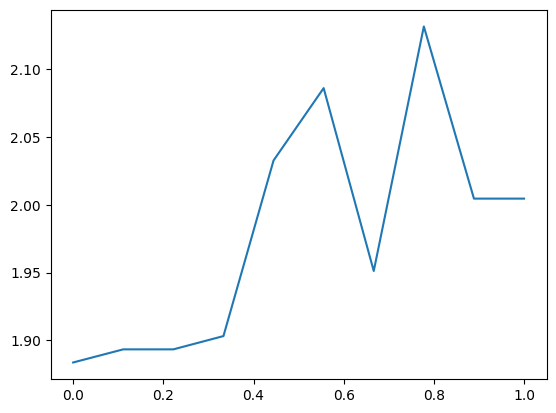

In [ ]:
import pysindy as ps
from pysindy.utils.odes import lorenz
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

states = ['beta','r']
inputs = ['delta', 'vx']
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# identity_lib = ps.IdentityLibrary()
poly_lib1 = ps.PolynomialLibrary(degree=1)
poly_lib2 = ps.PolynomialLibrary(degree=1)
lib_func = [lambda vx: 1/vx,
            lambda vx: 1/vx**2]
lib_func_names = [lambda vx: '1/vx',
                  lambda vx: '1/vx^2']

custom_lib = ps.CustomLibrary(library_functions=lib_func,
                              function_names=lib_func_names)

# 2 states: beta, r + 2 inputs: delta, vx
varuse_libwise_tmp = np.tile([0, 1, 2, 3],3)
varuse_libwise = np.reshape(varuse_libwise_tmp,[3,4])

varuse_libwise[0, 2] = 1        # delta: notin poly lib1
varuse_libwise[0, 3] = 1        # vx: notin poly lib1
varuse_libwise[1, 0] = 2        # beta: notin poly lib2
varuse_libwise[1, 1] = 2        # r: notin poly lib2
varuse_libwise[1, 3] = 2        # vx: notin poly lib2
varuse_libwise[2, 0] = 3        # beta: notin cust lib
varuse_libwise[2, 1] = 3        # r: notin cust lib
varuse_libwise[2, 2] = 3        # delta: notin cust lib
'''[[0, 1, 1, 1],--i.e. 2nd,3rd variable won't be used in lib1
    [2, 2, 2, 2],--i.e. only 2nd variable will be used in lib2
    [3, 3, 3, 3]]--i.e. only 3rd variable will be used in lib3
'''


tensoring_libs = [[1, 0, 1]]    # tensoring between library 1
                                # and 3 variables for fitting
                                # i.e. multiplying library 1
                                # and library 3 variables

gen_lib = ps.GeneralizedLibrary([poly_lib1, poly_lib2, custom_lib],
                                tensor_array=tensoring_libs,
                                inputs_per_library=varuse_libwise)

thresholds = np.linspace(0,1.0,10)
coeffs = []
mse = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)

dt = 0.002
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.arange(8,7,15)
x_test = solve_ivp(lorenz, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T



for i, th in enumerate(thresholds):
    ensemble_opt = ps.STLSQ(threshold = th)

    model = ps.SINDy(feature_names=states+inputs,
                     optimizer=ensemble_opt,
                     feature_library=gen_lib)

    model.fit(x_train, u=u_train, t = float(dp.Ts), quiet=True,ensemble = True)

    model.get_feature_names()

    print(f'==Threshold:{model.optimizer.threshold}==')
    print(f'Model:')
    model.print()
    ensemble_coefs = np.asarray(model.coef_list)
    mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
    median_ensemble_coefs = np.median(ensemble_coefs, axis=0)
    coeffs.append(model.coefficients())
    mse_val = model.score(x_train, t=dp.Ts, u=u_train,metric=mean_squared_error)
    mse.append(mse_val)
    print(f'--mse:{mse_val}--')

# plot_pareto(coeffs, ensemble_opt, model, thresholds, x_test, u_train, t_train)
plt.plot(thresholds,mse)


==Threshold:0.0==
Model:
(beta)' = -78.907 1 + -1165.468 beta + 16.333 r + -78.907 1 + 1.373 delta + 4616.897 1/vx + -67520.766 1/vx^2 + 4616.897 1 1/vx + -67520.766 1 1/vx^2 + 29343.367 beta 1/vx + 75173.937 beta 1/vx^2 + 1186.386 r 1/vx + -45251.778 r 1/vx^2
(r)' = 728.208 1 + 8830.120 beta + -355.668 r + 728.208 1 + 40.832 delta + -42602.436 1/vx + 622963.775 1/vx^2 + -42602.436 1 1/vx + 622963.775 1 1/vx^2 + -289478.140 beta 1/vx + 917680.164 beta 1/vx^2 + 6008.022 r 1/vx + 116160.677 r 1/vx^2
--mse:1.8837058159385605--
==Threshold:0.1111111111111111==
Model:
(beta)' = -6.163 beta + 0.437 r
(r)' = 7862.279 beta + -87.703 r + 41.230 delta + 0.465 1/vx + 0.465 1 1/vx + -229389.244 beta 1/vx + -9531.965 r 1/vx + 341040.316 r 1/vx^2
--mse:2.1425856950432807--
==Threshold:0.2222222222222222==
Model:
(beta)' = -15.402 beta + 1.315 delta + 8.739 r 1/vx + 198.073 r 1/vx^2
(r)' = 728.208 1 + 8830.120 beta + -355.668 r + 728.208 1 + 40.832 delta + -42602.436 1/vx + 622963.775 1/vx^2 + -42602

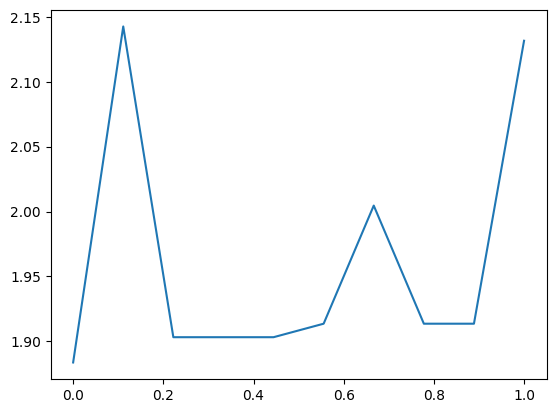

In [ ]:
import pysindy as ps
from pysindy.utils.odes import lorenz
from pysindy.utils.odes import linear_damped_SHO
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

states = ['beta','r']
inputs = ['delta', 'vx']
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# identity_lib = ps.IdentityLibrary()
poly_lib1 = ps.PolynomialLibrary(degree=1)
poly_lib2 = ps.PolynomialLibrary(degree=1)
lib_func = [lambda vx: 1/vx,
            lambda vx: 1/vx**2]
lib_func_names = [lambda vx: '1/vx',
                  lambda vx: '1/vx^2']

custom_lib = ps.CustomLibrary(library_functions=lib_func,
                              function_names=lib_func_names)

# 2 states: beta, r + 2 inputs: delta, vx
varuse_libwise_tmp = np.tile([0, 1, 2, 3],3)
varuse_libwise = np.reshape(varuse_libwise_tmp,[3,4])

varuse_libwise[0, 2] = 1        # delta: notin poly lib1
varuse_libwise[0, 3] = 1        # vx: notin poly lib1
varuse_libwise[1, 0] = 2        # beta: notin poly lib2
varuse_libwise[1, 1] = 2        # r: notin poly lib2
varuse_libwise[1, 3] = 2        # vx: notin poly lib2
varuse_libwise[2, 0] = 3        # beta: notin cust lib
varuse_libwise[2, 1] = 3        # r: notin cust lib
varuse_libwise[2, 2] = 3        # delta: notin cust lib
'''[[0, 1, 1, 1],--i.e. 2nd,3rd variable won't be used in lib1
    [2, 2, 2, 2],--i.e. only 2nd variable will be used in lib2
    [3, 3, 3, 3]]--i.e. only 3rd variable will be used in lib3
'''


tensoring_libs = [[1, 0, 1]]    # tensoring between library 1
                                # and 3 variables for fitting
                                # i.e. multiplying library 1
                                # and library 3 variables

gen_lib = ps.GeneralizedLibrary([poly_lib1, poly_lib2, custom_lib],
                                tensor_array=tensoring_libs,
                                inputs_per_library=varuse_libwise)

thresholds = np.linspace(0,1.0,10)
coeffs = []
mse = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)

dt = 0.002
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.arange(8,7,15)
x_test = solve_ivp(linear_damped_SHO, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T



for i, th in enumerate(thresholds):
    ensemble_opt = ps.STLSQ(threshold = th)

    model = ps.SINDy(feature_names=states+inputs,
                     optimizer=ensemble_opt,
                     feature_library=gen_lib)

    model.fit(x_train, u=u_train, t = float(dp.Ts), quiet=True,ensemble = True)

    model.get_feature_names()

    print(f'==Threshold:{model.optimizer.threshold}==')
    print(f'Model:')
    model.print()
    ensemble_coefs = np.asarray(model.coef_list)
    mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
    median_ensemble_coefs = np.median(ensemble_coefs, axis=0)
    coeffs.append(model.coefficients())
    mse_val = model.score(x_train, t=dp.Ts, u=u_train,metric=mean_squared_error)
    mse.append(mse_val)
    print(f'--mse:{mse_val}--')

#plot_pareto(coeffs, ensemble_opt, model, thresholds, x_test, u_train, t_test)
plt.plot(thresholds,mse)

==Threshold:0.0==
Model:
(beta)' = -78.907 1 + -1165.468 beta + 16.333 r + -78.907 1 + 1.373 delta + 4616.897 1/vx + -67520.766 1/vx^2 + 4616.897 1 1/vx + -67520.766 1 1/vx^2 + 29343.367 beta 1/vx + 75173.937 beta 1/vx^2 + 1186.386 r 1/vx + -45251.778 r 1/vx^2
(r)' = 728.208 1 + 8830.120 beta + -355.668 r + 728.208 1 + 40.832 delta + -42602.436 1/vx + 622963.775 1/vx^2 + -42602.436 1 1/vx + 622963.775 1 1/vx^2 + -289478.140 beta 1/vx + 917680.164 beta 1/vx^2 + 6008.022 r 1/vx + 116160.677 r 1/vx^2
--mse:1.8837058159385605--
==Threshold:0.1111111111111111==
Model:
(beta)' = -13.865 beta + 1.172 delta + 15.435 r 1/vx
(r)' = 9986.640 beta + -324.624 r + 41.186 delta + -89.793 1/vx + 2641.846 1/vx^2 + -89.793 1 1/vx + 2641.846 1 1/vx^2 + -367673.374 beta 1/vx + 2200727.816 beta 1/vx^2 + 4722.002 r 1/vx + 127895.814 r 1/vx^2
--mse:1.9512078359347034--
==Threshold:0.2222222222222222==
Model:
(beta)' = -15.402 beta + 1.315 delta + 8.739 r 1/vx + 198.073 r 1/vx^2
(r)' = 728.208 1 + 8830.120 be

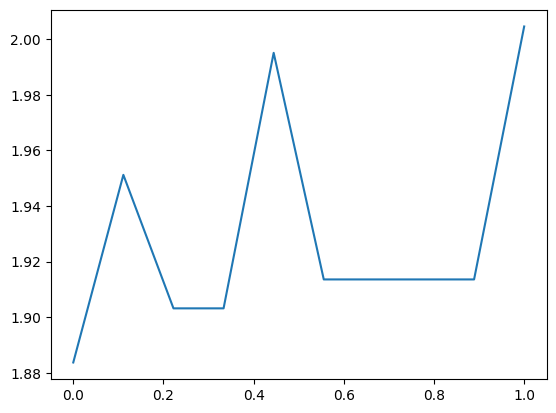

In [ ]:
import pysindy as ps
from pysindy.utils.odes import lorenz
from pysindy.utils.odes import linear_3D
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

states = ['beta','r']
inputs = ['delta', 'vx']
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# identity_lib = ps.IdentityLibrary()
poly_lib1 = ps.PolynomialLibrary(degree=1)
poly_lib2 = ps.PolynomialLibrary(degree=1)
lib_func = [lambda vx: 1/vx,
            lambda vx: 1/vx**2]
lib_func_names = [lambda vx: '1/vx',
                  lambda vx: '1/vx^2']

custom_lib = ps.CustomLibrary(library_functions=lib_func,
                              function_names=lib_func_names)

# 2 states: beta, r + 2 inputs: delta, vx
varuse_libwise_tmp = np.tile([0, 1, 2, 3],3)
varuse_libwise = np.reshape(varuse_libwise_tmp,[3,4])

varuse_libwise[0, 2] = 1        # delta: notin poly lib1
varuse_libwise[0, 3] = 1        # vx: notin poly lib1
varuse_libwise[1, 0] = 2        # beta: notin poly lib2
varuse_libwise[1, 1] = 2        # r: notin poly lib2
varuse_libwise[1, 3] = 2        # vx: notin poly lib2
varuse_libwise[2, 0] = 3        # beta: notin cust lib
varuse_libwise[2, 1] = 3        # r: notin cust lib
varuse_libwise[2, 2] = 3        # delta: notin cust lib
'''[[0, 1, 1, 1],--i.e. 2nd,3rd variable won't be used in lib1
    [2, 2, 2, 2],--i.e. only 2nd variable will be used in lib2
    [3, 3, 3, 3]]--i.e. only 3rd variable will be used in lib3
'''


tensoring_libs = [[1, 0, 1]]    # tensoring between library 1
                                # and 3 variables for fitting
                                # i.e. multiplying library 1
                                # and library 3 variables

gen_lib = ps.GeneralizedLibrary([poly_lib1, poly_lib2, custom_lib],
                                tensor_array=tensoring_libs,
                                inputs_per_library=varuse_libwise)

thresholds = np.linspace(0,1.0,10)
coeffs = []
mse = []
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)

dt = 0.002
t_test = np.arange(0, 15, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.arange(8,7,15)
x_test = solve_ivp(linear_damped_SHO, t_test_span, x0_test, t_eval=t_test, **integrator_keywords).y.T



for i, th in enumerate(thresholds):
    ensemble_opt = ps.STLSQ(threshold = th)

    model = ps.SINDy(feature_names=states+inputs,
                     optimizer=ensemble_opt,
                     feature_library=gen_lib)

    model.fit(x_train, u=u_train, t = float(dp.Ts), quiet=True,ensemble = True)

    model.get_feature_names()

    print(f'==Threshold:{model.optimizer.threshold}==')
    print(f'Model:')
    model.print()
    ensemble_coefs = np.asarray(model.coef_list)
    mean_ensemble_coefs = np.mean(ensemble_coefs, axis=0)
    median_ensemble_coefs = np.median(ensemble_coefs, axis=0)
    coeffs.append(model.coefficients())
    mse_val = model.score(x_train, t=dp.Ts, u=u_train,metric=mean_squared_error)
    mse.append(mse_val)
    print(f'--mse:{mse_val}--')

#plot_pareto(coeffs, ensemble_opt, model, thresholds, x_test, u_train, t_test)
plt.plot(thresholds,mse)

In [ ]:
x_train.shape

(251, 2)

In [ ]:
sparse_opt = ps.STLSQ(threshold = 0.48)
model = ps.SINDy(feature_names=states+inputs,
                     optimizer=sparse_opt,
                     feature_library=gen_lib)
model.fit(x_train, u=u_train, t = float(dp.Ts), quiet=True,ensemble = True)
model.get_feature_names()
model.print()

(beta)' = -13.865 beta + 1.172 delta + 15.435 r 1/vx
(r)' = 728.208 1 + 8830.120 beta + -355.668 r + 728.208 1 + 40.832 delta + -42602.436 1/vx + 622963.775 1/vx^2 + -42602.436 1 1/vx + 622963.775 1 1/vx^2 + -289478.140 beta 1/vx + 917680.164 beta 1/vx^2 + 6008.022 r 1/vx + 116160.677 r 1/vx^2


In [ ]:
x0_train = [1,2]
x_sim = model.simulate(x0_train,t_train,u=u_train)
x_sim_label = np.concatenate(([[1,2]], x_sim))

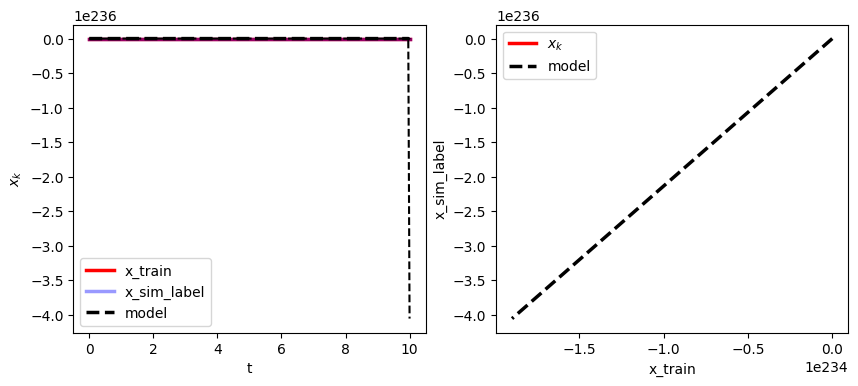

In [ ]:
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="x_train", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="x_sim_label", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim_label[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim_label[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim_label[:, 0], x_sim_label[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="x_train", ylabel="x_sim_label")
fig.show()

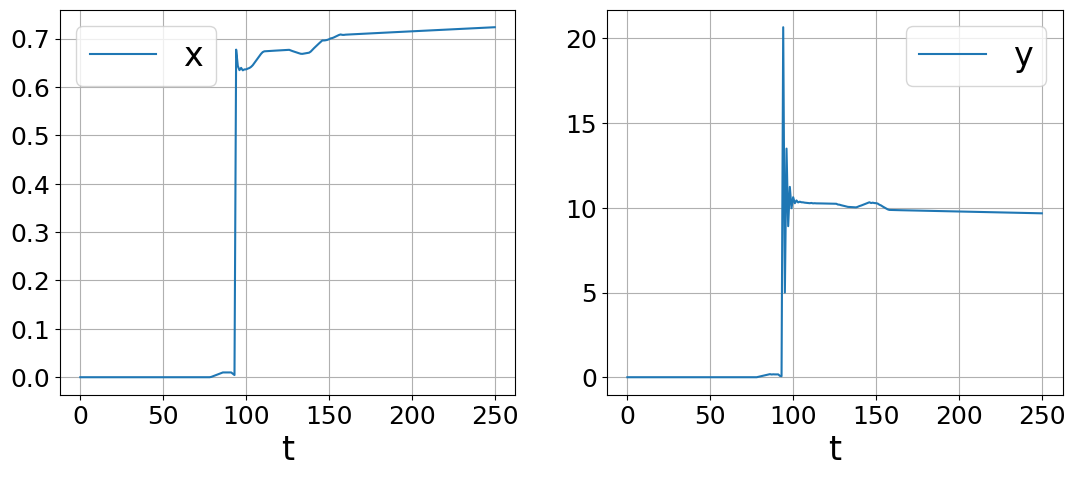

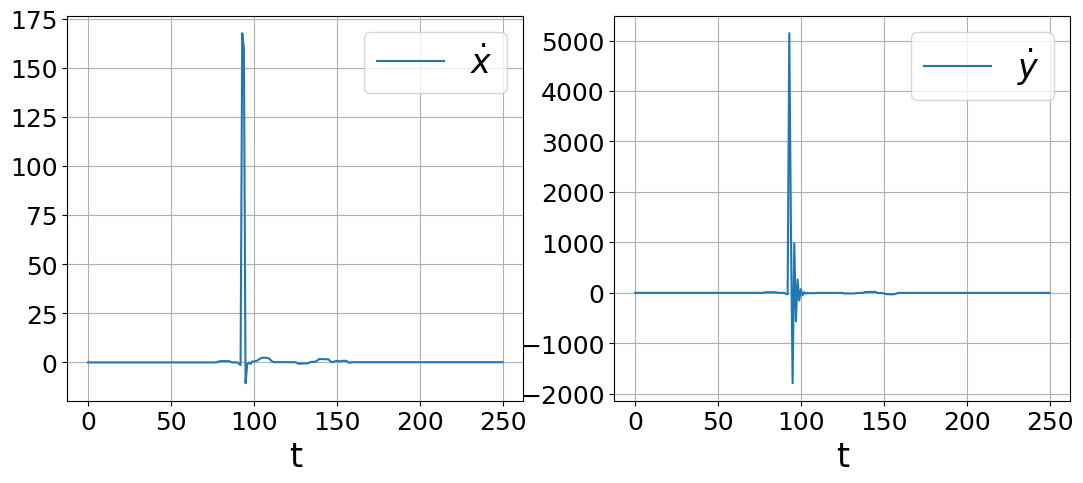

In [ ]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train
plot_data_and_derivative(x_train_added_noise, dt,
                         ps.FiniteDifference()._differentiate)

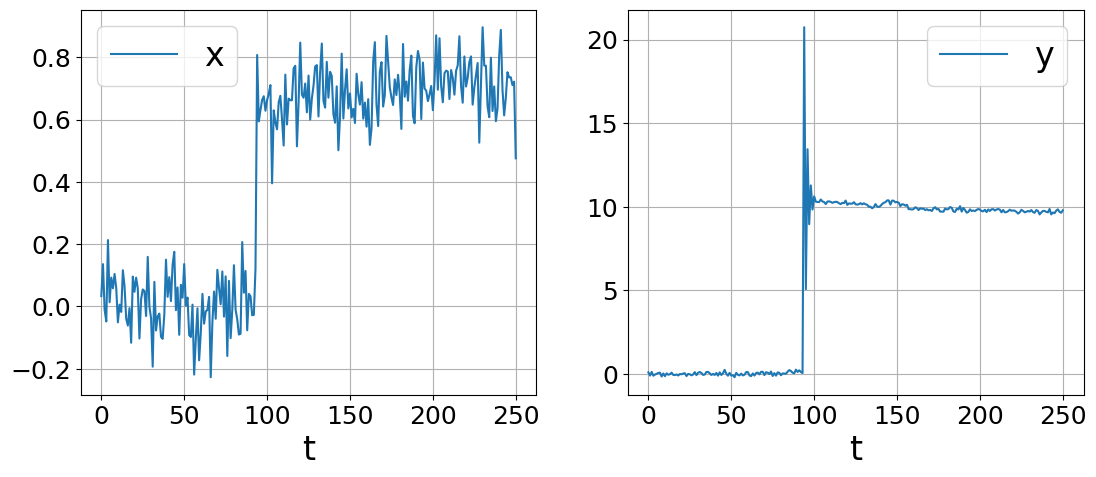

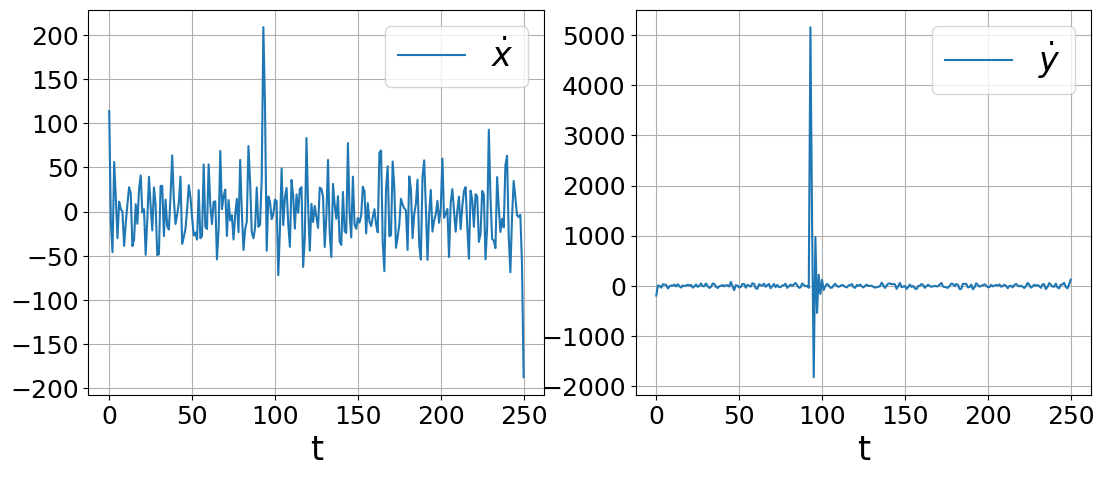

In [ ]:
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 50.0,  x_train.shape)
plot_data_and_derivative(x_train_added_noise, dt,
                         ps.FiniteDifference()._differentiate)

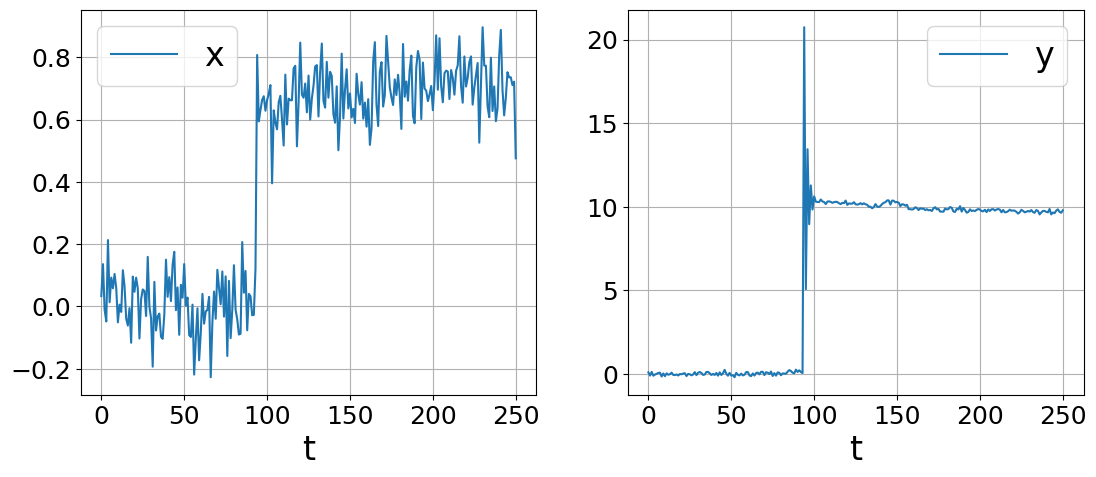

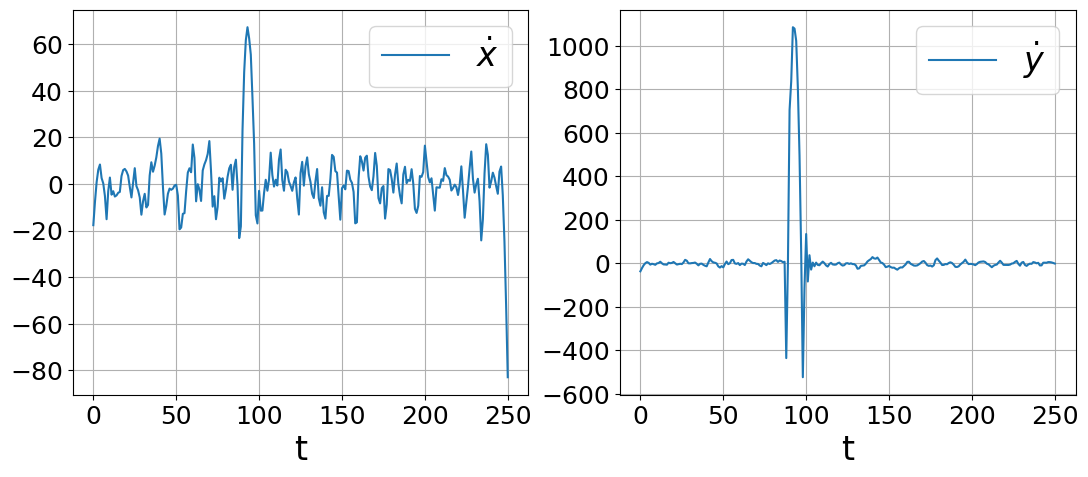

In [ ]:
plot_data_and_derivative(x_train_added_noise, dt,
                         ps.SmoothedFiniteDifference()._differentiate)

In [ ]:
sparse_regression_optimizer = ps.STLSQ(threshold = 0)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise,u = u_train, t=float(dp.Ts))
model.print()

(beta)' = -83.745 1 + 66.703 beta + -6.140 r + 17.176 delta + 5.525 vx + -19.224 beta^2 + 3.330 beta r + -5.952 beta delta + -2.284 beta vx + -0.026 r^2 + -0.391 r delta + 0.226 r vx + -0.175 delta^2 + -0.487 delta vx + -0.091 vx^2
(r)' = 636.239 1 + -154.591 beta + -69.437 r + 164.456 delta + -41.503 vx + 31.210 beta^2 + 39.620 beta r + -145.900 beta delta + 5.341 beta vx + -1.362 r^2 + 5.858 r delta + 2.413 r vx + 18.914 delta^2 + -8.046 delta vx + 0.675 vx^2


In [ ]:
# Fit a regular SINDy model with 5% added Gaussian noise
rmse = mean_squared_error(x_train, np.zeros(x_train.shape), squared=False)
x_train_added_noise = x_train + np.random.normal(0, rmse / 20.0,  x_train.shape)
sparse_regression_optimizer = ps.STLSQ(threshold=0)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
model.print()

(beta)' = 4.977 1 + -4.884 beta + -5.382 r + -33.251 beta^2 + 5.490 beta r + 0.309 r^2
(r)' = 55.009 1 + 196.098 beta + -87.401 r + -229.063 beta^2 + 8.692 beta r + 7.370 r^2


In [ ]:
x_train.shape

(251, 2)

In [ ]:
# Fit a regular SINDy model with 5% added Gaussian noise
sparse_regression_optimizer = ps.SR3(threshold=0.5)
model = ps.SINDy(feature_names=feature_names, optimizer=sparse_regression_optimizer)
model.fit(x_train_added_noise, t=dt)
print("SR3 model, no constraints:")
model.print()
#x_sim = model.simulate(x0_test, t=t_test)

# Figure out how many library features there will be
library = ps.PolynomialLibrary()
library.fit(x_train)
n_features = library.n_output_features_

# Set constraints
n_targets = x_train.shape[1]
constraint_rhs = np.array([0, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((2, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) = 0
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# 1 * (x0 coefficient) = 28
constraint_lhs[1, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    threshold=0.5,
    thresholder="l1",
)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=feature_names
)
model.fit(x_train_added_noise, t=dt)
print("ConstrainedSR3 model, equality constraints:")
model.print()
#constrained_x_sim = model.simulate(x0_test, t=t_test)
#make_3d_plots(x_test, x_sim, constrained_x_sim,
              #"ConstrainedSR3, equality constraints")

# Repeat with inequality constraints
eps = 0.5
constraint_rhs = np.array([eps, eps, 28])

# One row per constraint, one column per coefficient
constraint_lhs = np.zeros((3, n_targets * n_features))

# 1 * (x0 coefficient) + 1 * (x1 coefficient) <= eps
constraint_lhs[0, 1] = 1
constraint_lhs[0, 2] = 1

# -eps <= 1 * (x0 coefficient) + 1 * (x1 coefficient)
constraint_lhs[1, 1] = -1
constraint_lhs[1, 2] = -1

# 1 * (x0 coefficient) <= 28
constraint_lhs[2, 1 + n_features] = 1

optimizer = ps.ConstrainedSR3(
    constraint_rhs=constraint_rhs,
    constraint_lhs=constraint_lhs,
    threshold=0.5,
    inequality_constraints=True,
    thresholder="l1",
)
model = ps.SINDy(
    optimizer=optimizer, feature_library=library, feature_names=feature_names
)
model.fit(x_train_added_noise,t=float(dp.Ts))
print("ConstrainedSR3 model, inequality constraints:")
model.print()
# constrained_x_sim = model.simulate(x0_test, t=t_test)
# make_3d_plots(
#     x_test, x_sim, constrained_x_sim,
#     "ConstrainedSR3, inequality constraints"
# )

SR3 model, no constraints:
(beta)' = 5.647 1 + -13.720 beta + -3.129 r + -57.330 beta^2 + 9.422 beta r
(r)' = 55.009 1 + 196.098 beta + -87.401 r + -229.063 beta^2 + 8.692 beta r + 7.370 r^2
ConstrainedSR3 model, equality constraints:
(beta)' = 4.062 1 + 5.017 beta + -5.017 r + -30.654 beta^2 + 3.610 beta r
(r)' = 58.778 1 + 27.500 beta + -81.889 r + -244.463 beta^2 + 27.325 beta r + 6.256 r^2
ConstrainedSR3 model, inequality constraints:
(beta)' = 0.232 1 + -0.179 beta + -0.266 r + -1.418 beta^2 + 0.236 beta r + 0.016 r^2
(r)' = 2.736 1 + 9.761 beta + -4.364 r + -11.221 beta^2 + 0.408 beta r + 0.369 r^2


/usr/local/lib/python3.10/dist-packages/cvxpy/problems/problem.py:1387: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


In [ ]:
# Fit an estimator
estimator = ps.deeptime.SINDyEstimator(t_default=dt)
estimator.fit(x_train,u = u_train,t = float(dp.Ts));

In [ ]:
# Extract a model
model = estimator.fetch_model()

# Compare SINDy-predicted derivatives with finite difference derivatives
print('Model score: %f' % model.score(x_train,u = u_train, t=float(dp.Ts)))

Model score: 0.992023


In [ ]:
estimator = ps.deeptime.SINDyEstimator(
    optimizer=ps.SR3(threshold=0.2, max_iter=50),
    feature_library=gen_lib
)
estimator.fit(x_train,u = u_train,t=float(dp.Ts))

model = estimator.fetch_model()
model.print()

(x0)' = -43.175 1 + -2119.924 x0 + 1220.430 x1 + -43.177 1 + -2119.923 x0 + -3371.212 u0 + 1679.837 1/vx + -24501.477 1/vx^2 + 1679.837 1 1/vx + -24501.477 1 1/vx^2 + 103005.708 x0 1/vx + -1234939.533 x0 1/vx^2 + -63230.590 x1 1/vx + 814866.790 x1 1/vx^2 + 1679.837 1 1/vx + -24501.477 1 1/vx^2 + 103005.708 x0 1/vx + -1234939.533 x0 1/vx^2 + 177644.512 u0 1/vx + -2329871.392 u0 1/vx^2
(x1)' = 337.005 1 + 21102.885 x0 + -13381.956 x1 + 337.022 1 + 21102.883 x0 + 36634.145 u0 + -13097.342 1/vx + 190810.703 1/vx^2 + -13097.342 1 1/vx + 190810.703 1 1/vx^2 + -1099739.734 x0 1/vx + 14161051.336 x0 1/vx^2 + 703868.339 x1 1/vx + -9216085.975 x1 1/vx^2 + -13097.342 1 1/vx + 190810.703 1 1/vx^2 + -1099739.734 x0 1/vx + 14161051.336 x0 1/vx^2 + -1932702.454 u0 1/vx + 25425811.681 u0 1/vx^2


In [ ]:
import pysindy as ps
from pysindy.utils.odes import lorenz
from pysindy.utils.odes import linear_3D
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

states = ['beta','r']
inputs = ['delta', 'vx']
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# identity_lib = ps.IdentityLibrary()
poly_lib1 = ps.PolynomialLibrary(degree=1)
poly_lib2 = ps.PolynomialLibrary(degree=1)
lib_func = [lambda vx: 1/vx,
            lambda vx: 1/vx**2]
lib_func_names = [lambda vx: '1/vx',
                  lambda vx: '1/vx^2']

custom_lib = ps.CustomLibrary(library_functions=lib_func,
                              function_names=lib_func_names)

# 2 states: beta, r  +   2 inputs: delta, vx
varuse_libwise_tmp = np.tile([0, 1, 2, 3],3)
varuse_libwise = np.reshape(varuse_libwise_tmp,[3,4])

varuse_libwise[0, 2] = 1        # delta: notin poly lib1
varuse_libwise[0, 3] = 1        # vx: notin poly lib1
varuse_libwise[1, 0] = 2        # beta: notin poly lib2
varuse_libwise[1, 1] = 2        # r: notin poly lib2
varuse_libwise[1, 3] = 2        # vx: notin poly lib2
varuse_libwise[2, 0] = 3        # beta: notin cust lib
varuse_libwise[2, 1] = 3        # r: notin cust lib
varuse_libwise[2, 2] = 3        # delta: notin cust lib
'''[[0, 1, 1, 1],--i.e. 2nd,3rd variable won't be used in lib1
    [2, 2, 2, 2],--i.e. only 2nd variable will be used in lib2
    [3, 3, 3, 3]]--i.e. only 3rd variable will be used in lib3
'''


tensoring_libs = [[1, 0, 1]]    # tensoring between library 1
                                # and 3 variables for fitting
                                # i.e. multiplying library 1
                                # and library 3 variables

gen_lib = ps.GeneralizedLibrary([poly_lib1, poly_lib2, custom_lib],
                                tensor_array=tensoring_libs,
                                inputs_per_library=varuse_libwise)

### **GridSearchCV Implementation**

---



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

model = ps.SINDy(t_default=dt)

param_grid = {
    "optimizer__threshold": [0,0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [gen_lib, ps.FourierLibrary()],
    "differentiation_method__order": [1]
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train,u=u_train,t = float(dp.Ts))

print("Best parameters:", search.best_params_)
search.best_estimator_.print()
print('Model score: %f' % search.best_estimator_.score(x_train,u = u_train, t=float(dp.Ts)))


Best parameters: {'differentiation_method__order': 1, 'feature_library': <pysindy.feature_library.generalized_library.GeneralizedLibrary object at 0x7dbdbae4b160>, 'optimizer__alpha': 0.01, 'optimizer__threshold': 0}
(x0)' = 0.018 1 + -3.905 x0 + -2.595 x1 + 0.018 1 + 2.688 u0 + -0.982 1/vx + 13.249 1/vx^2 + -0.982 1 1/vx + 13.249 1 1/vx^2 + -535.908 x0 1/vx + 8304.937 x0 1/vx^2 + 115.079 x1 1/vx + -1228.336 x1 1/vx^2
(x1)' = 0.001 1 + 335.553 x0 + -30.209 x1 + 0.001 1 + 82.195 u0 + -0.295 1/vx + 8.171 1/vx^2 + -0.295 1 1/vx + 8.171 1 1/vx^2 + -1285.460 x0 1/vx + -20888.872 x0 1/vx^2 + -470.128 x1 1/vx + 5306.285 x1 1/vx^2
Model score: 0.999998


/usr/local/lib/python3.10/dist-packages/pysindy/optimizers/stlsq.py:201: UserWarning: Sparsity parameter is too big (0.1) and eliminated all coefficients
  warnings.warn(


In [ ]:
x0_train = [0,0]
x_sim = search.best_estimator_.simulate(x0_train,t_train,u=u_train)
x_sim_label = np.concatenate(([[0,0]], x_sim))

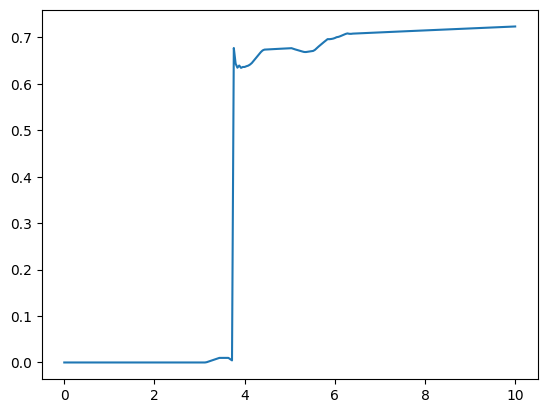

In [ ]:
plt.plot(t_train,x_train[:,0])
plt.show()

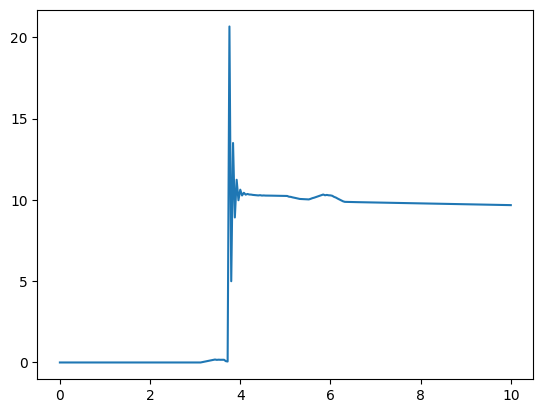

In [ ]:
plt.plot(t_train,x_train[:,1])
plt.show()

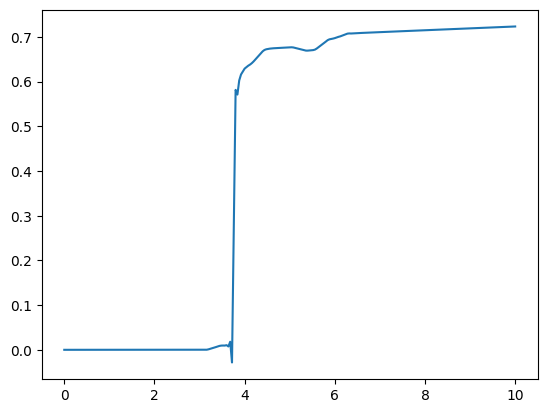

In [ ]:
plt.plot(t_train,x_sim_label[:,0])
plt.show()

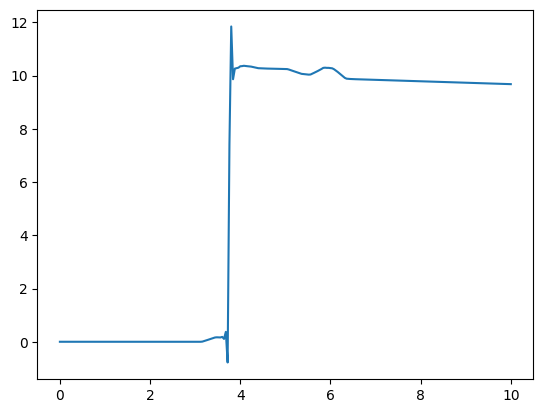

In [ ]:
plt.plot(t_train,x_sim_label[:,1])
plt.show()

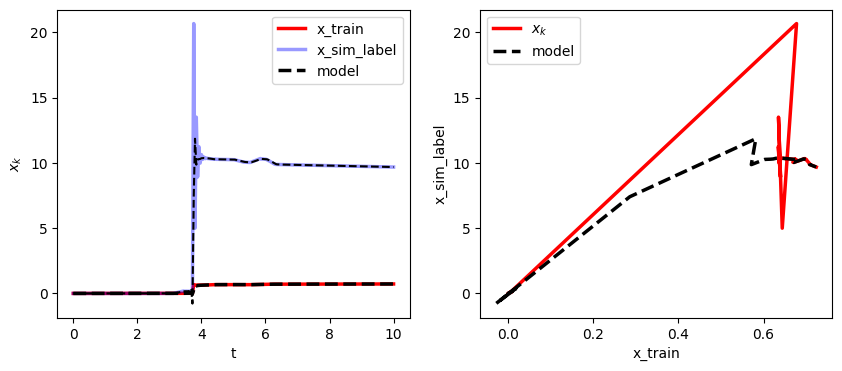

In [ ]:
plot_kws = dict(linewidth=2.5)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_train, x_train[:, 0], "r", label="x_train", **plot_kws)
axs[0].plot(t_train, x_train[:, 1], "b", label="x_sim_label", alpha=0.4, **plot_kws)
axs[0].plot(t_train, x_sim_label[:, 0], "k--", label="model", **plot_kws)
axs[0].plot(t_train, x_sim_label[:, 1], "k--")
axs[0].legend()
axs[0].set(xlabel="t", ylabel="$x_k$")

axs[1].plot(x_train[:, 0], x_train[:, 1], "r", label="$x_k$", **plot_kws)
axs[1].plot(x_sim_label[:, 0], x_sim_label[:, 1], "k--", label="model", **plot_kws)
axs[1].legend()
axs[1].set(xlabel="x_train", ylabel="x_sim_label")
fig.show()

### **Elastic Net Regression**

---



In [ ]:
from sklearn.linear_model import ElasticNet

model = ps.SINDy(feature_names=states+inputs,optimizer=ElasticNet(l1_ratio=0.9, fit_intercept=False), feature_library=gen_lib,t_default=dt)
model.fit(x_train, u=u_train, t = float(dp.Ts))
model.print()
print('Model score: %f' % model.score(x_train,u = u_train, t=float(dp.Ts)))

(beta)' = 0.000
(r)' = -7.051 r + 25.384 delta
Model score: 0.191297


### **Polynomial Regression**

---

\begin{equation*}
\begin{aligned}
& \frac{d \beta}{d t}=\left[-\frac{2 C_f+2 C_r}{m v_x}\right] \beta+\left[-\frac{2 C_f l_f-2 C_r l_r}{m v_x^2}\right] r - r +\frac{2 C_f}{m v_x} \delta \\
& \frac{d r}{d t}=-\left[\frac{2 C_f l_f-2 C_r l_r}{I_z}\right] \beta+\left[-\frac{2 C_f l_f^2+2 C_r l_r^2}{I_z v_x}\right] r+\frac{2 C_f l_f}{I_z} \delta+\frac{M_z}{I_z} .
\end{aligned}
\end{equation*}

In [ ]:
import pysindy as ps
from pysindy.utils.odes import lorenz
from pysindy.utils.odes import linear_3D
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

states = ['beta','r']
inputs = ['delta', 'vx']
integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

# identity_lib = ps.IdentityLibrary()
poly_lib1 = ps.PolynomialLibrary(degree=1)
poly_lib2 = ps.PolynomialLibrary(degree=1)
lib_func = [lambda vx: 1/vx,
            lambda vx: 1/vx**2]
lib_func_names = [lambda vx: '1/vx',
                  lambda vx: '1/vx^2']

custom_lib = ps.CustomLibrary(library_functions=lib_func,
                              function_names=lib_func_names)

# # 2 states: beta, r  +   2 inputs: delta, vx
# varuse_libwise_tmp = np.tile([0, 1, 2, 3],3)
# varuse_libwise = np.reshape(varuse_libwise_tmp,[3,4])

# # varuse_libwise[0, 2] = 1        # delta: notin poly lib1
# varuse_libwise[0, 3] = 1        # vx: notin poly lib1
# varuse_libwise[1, 0] = 2        # beta: notin poly lib2
# varuse_libwise[1, 2] = 2        # delta: notin poly lib2
# varuse_libwise[1, 3] = 2        # vx: notin poly lib2
# varuse_libwise[2, 0] = 3        # beta: notin cust lib
# varuse_libwise[2, 1] = 3        # r: notin cust lib
# varuse_libwise[2, 2] = 3        # delta: notin cust lib
# '''[[0, 1, 1, 1],--i.e. 2nd,3rd variable won't be used in lib1
#     [2, 2, 2, 2],--i.e. only 2nd variable will be used in lib2
#     [3, 3, 3, 3]]--i.e. only 3rd variable will be used in lib3
# '''

# Define the variable usage matrix for tensoring
varuse_libwise = np.array([[0, 1, 0, 0],   # Using only the 'vx' variable in the 1st library
                           [2, 0, 0, 2],   # Using only the 'vx' variable in the 2nd library
                           [3, 3, 3, 3]])  # Using all variables in the custom library




tensoring_libs = [[1, 0, 1],[0,1,1]]    # tensoring between library 1
                                # and 3 variables for fitting
                                # i.e. multiplying library 1
                                # and library 3 variables

gen_lib = ps.GeneralizedLibrary([poly_lib1, poly_lib2, custom_lib],
                                tensor_array=tensoring_libs,
                                inputs_per_library=varuse_libwise)

In [ ]:
sparse_opt = ps.STLSQ(threshold = 0.2)
model = ps.SINDy(feature_names=states+inputs,
                     optimizer=sparse_opt,
                     feature_library=gen_lib)
model.fit(x_train, u=u_train, t = float(dp.Ts), quiet=True,ensemble = True)
model.get_feature_names()
model.print()
print('Model score: %f' % model.score(x_train,u = u_train, t=float(dp.Ts)))

(beta)' = -610.786 beta + -610.786 beta + 17.742 delta + 16802.559 beta 1/vx + 1933.065 r 1/vx + -53376.977 r 1/vx^2 + 16802.559 beta 1/vx + -459.699 delta 1/vx
(r)' = 337.005 1 + 21102.885 beta + -13381.956 r + 337.022 1 + 21102.883 beta + 36634.145 delta + -13097.342 1/vx + 190810.703 1/vx^2 + -13097.342 1 1/vx + 190810.703 1 1/vx^2 + -1099739.734 beta 1/vx + 14161051.336 beta 1/vx^2 + 703868.339 r 1/vx + -9216085.975 r 1/vx^2 + -13097.342 1 1/vx + 190810.703 1 1/vx^2 + -1099739.734 beta 1/vx + 14161051.336 beta 1/vx^2 + -1932702.454 delta 1/vx + 25425811.681 delta 1/vx^2
Model score: 0.957423


In [ ]:
x0_train = [0,0]
x_sim = search.best_estimator_.simulate(x0_train,t_train,u=u_train)
x_sim_label = np.concatenate(([[0,0]], x_sim))

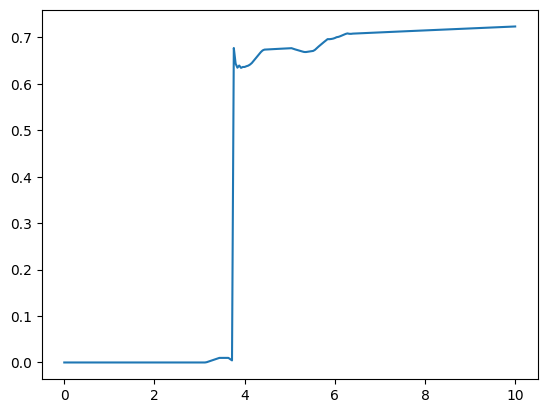

In [ ]:
plt.plot(t_train,x_train[:,0])
plt.show()

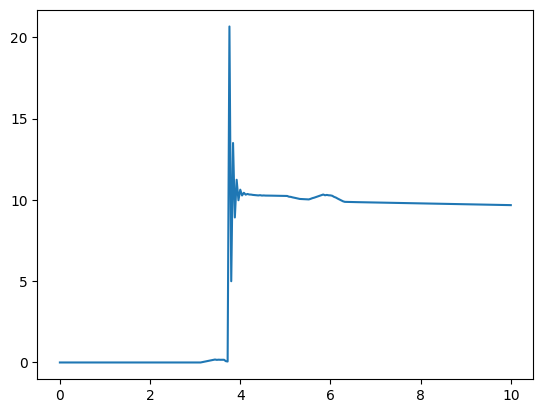

In [ ]:
plt.plot(t_train,x_train[:,1])
plt.show()

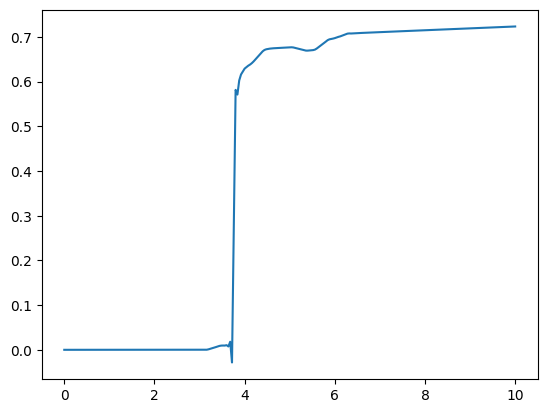

In [ ]:
plt.plot(t_train,x_sim_label[:,0])
plt.show()

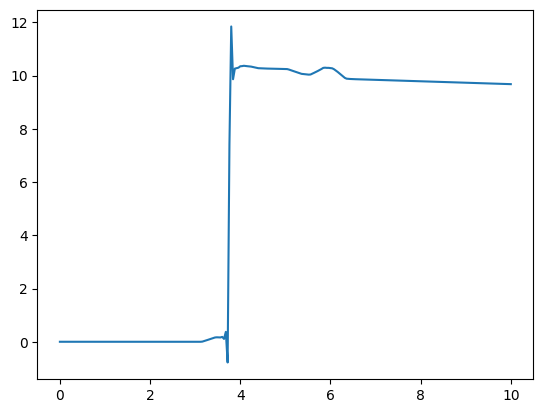

In [ ]:
plt.plot(t_train,x_sim_label[:,1])
plt.show()